In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Concatenate, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

In [7]:
def train_and_evaluate_gru_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    # Load your data from the Excel file
    mgh_data = pd.read_excel("gru-datasets.xlsx")

    # Select relevant features
    features = ['timesteps', f'{target_variable} (Predicted GL)', f'{target_variable} (Predicted NN)']
    
    X = mgh_data[features]
    y = mgh_data[f'{target_variable} (Actual)']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for GRU input (samples, timesteps, features)
    X_train_q_physics = X_train_scaled[:, 1].reshape(-1, 1, 1)
    X_train_q_nn = X_train_scaled[:, 2].reshape(-1, 1, 1)
    X_test_q_physics = X_test_scaled[:, 1].reshape(-1, 1, 1)
    X_test_q_nn = X_test_scaled[:, 2].reshape(-1, 1, 1)

    if flag_train:
        # Define the input shapes
        time_steps = X_train_q_physics.shape[1]  # Should be 1 since we're using only one feature per time step

        # Inputs
        input_q_physics = Input(shape=(time_steps, 1), name='input_q_physics')
        input_q_nn = Input(shape=(time_steps, 1), name='input_q_nn')

        # Concatenate the features
        input_features = Concatenate()([input_q_physics, input_q_nn])

        # GRU Layer to process the time series data
        gru_output = GRU(units=64, return_sequences=False)(input_features)

        # Dense layers to predict w_physics and w_nn
        # w_physics = Dense(1, activation='linear', name='w_physics')(gru_output)
        # w_nn = Dense(1, activation='linear', name='w_nn')(gru_output)
        # Dense layers to predict w_physics and w_nn, using sigmoid to constrain them to [0, 1]
        w_physics = Dense(1, activation='softmax', name='w_physics')(gru_output)
        w_nn = Dense(1, activation='softmax', name='w_nn')(gru_output)

        # Define the model to output the weights
        weights_model = Model(inputs=[input_q_physics, input_q_nn], outputs=[w_physics, w_nn])

        # Compile the model
        weights_model.compile(optimizer='adam', loss='mse', metrics=['mae', r2_score_metric])

        # Train the model
        history = weights_model.fit([X_train_q_physics, X_train_q_nn], y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

        # Save the model and scaler
        weights_model.save(f'gru-models/{target_variable}_weights_model.keras')
        joblib.dump(scaler, f'gru-models/{target_variable}_gru_scaler.pkl')

        # Predict weights on test data
        predicted_w_physics, predicted_w_nn = weights_model.predict([X_test_q_physics, X_test_q_nn])
    else:
        # Load the model and scaler
        loaded_model = load_model(f'gru-models/{target_variable}_weights_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        scaler = joblib.load(f'gru-models/{target_variable}_gru_scaler.pkl')

        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        X_test_q_physics = X_test_scaled[:, 1].reshape(-1, 1, 1)
        X_test_q_nn = X_test_scaled[:, 2].reshape(-1, 1, 1)

        # Predict weights on test data
        predicted_w_physics, predicted_w_nn = loaded_model.predict([X_test_q_physics, X_test_q_nn])
        print("predicted_w_physics : ", predicted_w_physics)
        print("predicted_w_nn : ", predicted_w_nn)

    # Unscale the relevant features before using them to calculate y_hat
    X_test_unscaled = scaler.inverse_transform(X_test_scaled.reshape(X_test_scaled.shape[0], -1))

    # Calculate y_hat using the predicted weights and the unscaled features
    y_hat_test = X_test_unscaled[:, 1] * predicted_w_physics.squeeze() + X_test_unscaled[:, 2] * predicted_w_nn.squeeze()

    print("y_test: ", y_test)
    print("y_hat_test : ", y_hat_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)

    if flag_train:
        # Plot training history
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Scatter plot of actual vs. predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()

    # Plot of actual vs. predicted over time
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 475.7916 - w_physics_mae: 21.7955 - val_loss: 475.2708 - val_w_physics_mae: 21.7868
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 475.9524 - w_physics_mae: 21.8001 - val_loss: 475.2708 - val_w_physics_mae: 21.7868
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 474.9944 - w_physics_mae: 21.7789 - val_loss: 475.2708 - val_w_physics_mae: 21.7868
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 475.0152 - w_physics_mae: 21.7781 - val_loss: 475.2708 - val_w_physics_mae: 21.7868
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 472.2401 - w_physics_mae: 21.7143 - val_loss: 475.2708 - val_w_physics_mae: 21.7868
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 475.5394 - w_physics_mae: 21.7898 - val_loss: 475.2708 - val_w_physics_mae: 21.7868
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 475.9043 - w_physics_mae: 21.7977 - val_loss: 475.2708 - val_w_physics_mae: 21.78

c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (15, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


y_test:  413     24.954382
316     22.526676
1034    23.459897
65      22.710804
1024    23.259234
661     23.002238
175     23.768437
824     22.175499
649     22.967504
231     21.574950
198     23.558364
845     21.990108
1108    21.698055
1394    21.453012
358     22.557055
Name: Temperature In (Actual), dtype: float64
y_hat_test :  [52.67955834 45.10339115 46.89663931 45.47264706 46.81766791 46.30744361
 48.03233556 45.21694606 46.2615693  44.44842868 47.32471497 44.85635259
 44.29928135 44.015458   45.27278691]

Target Variable: Temperature In
MAE: 23.42
R²: -655.10


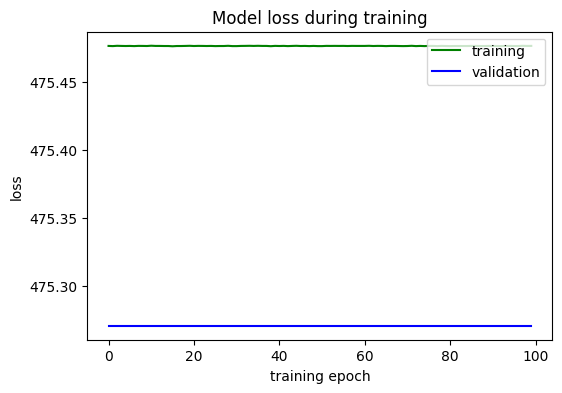

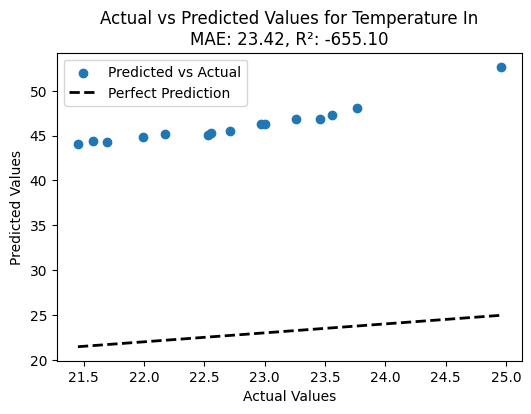

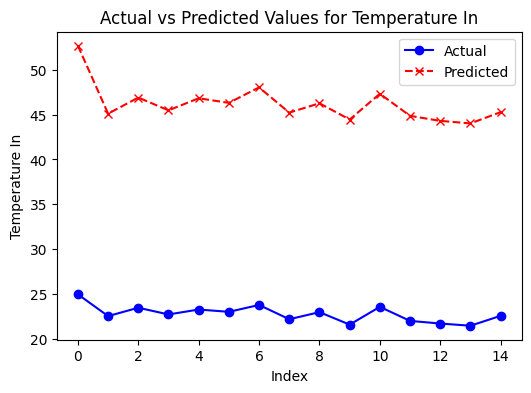

In [8]:
train_and_evaluate_gru_model(target_variable='Temperature In', flag_train=True)